# Starting Up

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import csv
import params

[[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [107 103 153]
 [108 103 155]
 [111 107 159]
 [116 109 169]
 [119 112 173]
 [119 111 174]
 [119 111 174]
 [118 110 173]
 [118 110 173]
 [120 111 172]
 [122 112 173]
 [123 113 174]
 [123 113 174]
 [124 115 172]
 [124 115 172]
 [125 116 173]
 [125 116 173]
 [125 116 173]
 [124 115 172]
 [124 113 174]
 [123 112 173]
 [122 111 172]
 [122 111 172]
 [120 110 171]
 [120 110 

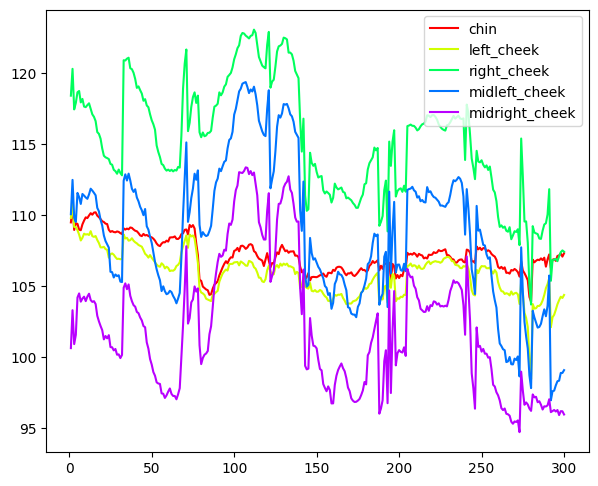

In [2]:
data = np.load('/Users/henryschnieders/Documents/Research/My_Data/red_p3_regions.npy', allow_pickle=True)


reg1 = []
reg2 = []
reg3 = []
reg4 = []
reg5 = []

colormap = matplotlib.colormaps['hsv']

for frame in data:
    print(frame[0][0])
    break

for frame in data:
    reg1 += [np.mean(frame[0][0])]
    reg2 += [np.mean(frame[0][1])]
    reg3 += [np.mean(frame[0][2])]
    reg4 += [np.mean(frame[0][3])]
    reg5 += [np.mean(frame[0][4])]


print(reg1)

domain = np.linspace(1, len(data), len(data))


figure = plt.figure(figsize = [7,5.75])
plt.plot(domain, reg1, color = colormap(0), label = 'chin')
plt.plot(domain, reg2, color = colormap(0.2), label = 'left_cheek')
plt.plot(domain, reg3, color = colormap(0.4), label = 'right_cheek')
plt.plot(domain, reg4, color = colormap(0.6), label = 'midleft_cheek')
plt.plot(domain, reg5, color = colormap(0.8), label = 'midright_cheek')

plt.legend()


plt.savefig('/Users/henryschnieders/desktop/10bitfig.jpg', dpi = 1200, bbox_inches = 'tight', pad_inches = 0.0)
plt.show()


#I moved at the end of the video 
#data might be grayscale 

In [3]:
# ---------------------------------------------------------------------
# Face-region FB tracker (uses OpenCV)
# Henry Schnieders · 2025-06-03
# ---------------------------------------------------------------------
import cv2
import numpy as np

# ---------- adjustable params ---------- #
GRID_SIDE        = 9          # 9x9 = 81 points per seed
GRID_SPACING_PX  = 2          # grid pitch inside each patch
FB_THRESH_PX     = 1.0        # max forward–backward error
MIN_POINTS_KEEP  = 10         # discard region avg if fewer survive

lk_params = dict(winSize  =(21, 21),
                 maxLevel =3,
                 criteria =(cv2.TERM_CRITERIA_EPS |
                            cv2.TERM_CRITERIA_COUNT, 30, 0.01))

# ---------- helper: build a dense grid around (x, y) ---------- #
def make_grid(x, y, side=GRID_SIDE, pitch=GRID_SPACING_PX):
    half = (side // 2) * pitch
    xs = np.arange(x - half, x + half + 1, pitch)
    ys = np.arange(y - half, y + half + 1, pitch)
    xv, yv = np.meshgrid(xs, ys)
    return np.column_stack((xv.ravel(), yv.ravel())).astype(np.float32)

# ---------- seed points from your params helpers ---------- #


def get_region_seeds(img, bbox):

    x_c     = params.chin(img, bbox, DELTA  = 0, region = 'false')[1][0]
    y_c     = params.chin(img, bbox,  DELTA = 0, region = 'false')[0][0]

    x_mlc = params.midleft_cheek(img, bbox, DELTA = 0, region = 'false')[1][0]
    y_mlc = params.midleft_cheek(img, bbox, DELTA = 0, region = 'false')[0][0]

    x_mrc = params.midright_cheek(img, bbox, DELTA = 0, region = 'false')[1][0]
    y_mrc = params.midright_cheek(img, bbox, DELTA = 0, region = 'false')[0][0]

    x_lc  = params.left_cheek(img, bbox, DELTA = 0, region = 'false')[1][0]
    y_lc  = params.left_cheek(img, bbox, DELTA = 0, region = 'false')[0][0]

    x_rc  = params.right_cheek(img, bbox, DELTA = 0, region = 'false')[1][0]
    y_rc  = params.right_cheek(img, bbox, DELTA = 0, region = 'false')[0][0]

    return [make_grid(x_c,  y_c),
            make_grid(x_mlc, y_mlc),
            make_grid(x_mrc, y_mrc),
            make_grid(x_lc,  y_lc),
            make_grid(x_rc,  y_rc)]

# ---------- main routine ---------- #
# ---------- main routine (re-written) ---------- #
def fb_track_regions(frames_rgb):
    """
    Forward-Backward LK tracking on five face regions.
    Returns 5 NumPy arrays of length (#frames-1) with region intensities.
    """
    # 1. RGB → gray (OpenCV uses BGR order)
    frames = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames_rgb]
    H, W   = frames[0].shape

    # 2. seed a dense grid around each landmark in frame 0
    bbox        = [0, 0, W, H]
    region_pts  = get_region_seeds(frames_rgb[0], bbox)   # list[5] (N,2)
    n_regions   = len(region_pts)

    # 3. book-keeping arrays
    pts_all   = np.vstack(region_pts).astype(np.float32)  # (M,2)
    reg_index = np.concatenate([[i]*len(p)
                                for i, p in enumerate(region_pts)])  # (M,)
    valid     = np.ones(len(pts_all), dtype=bool)         # live tracks mask
    signals   = [[] for _ in range(n_regions)]            # intensity traces

    # ------------------------------------------------------------
    #                main time loop
    # ------------------------------------------------------------
    for t in range(len(frames) - 1):
        prev = frames[t]
        nxt  = frames[t + 1]

        # ----- 3-level pyramidal LK forward & backward -----
        p1, st_fwd, _ = cv2.calcOpticalFlowPyrLK(
            prev, nxt, pts_all[valid], None, **lk_params
        )
        p0r, st_bwd, _ = cv2.calcOpticalFlowPyrLK(
            nxt, prev, p1, None, **lk_params
        )

        # LK can return shape (N,1,2); squeeze to (N,2)
        p1  = p1.reshape(-1, 2)
        p0r = p0r.reshape(-1, 2)

        fb_err = np.linalg.norm(pts_all[valid] - p0r, axis=1)
        good_mask_local = (
            (st_fwd.flatten() == 1)
            & (st_bwd.flatten() == 1)
            & (fb_err < FB_THRESH_PX)
        )

        # -------- map the LOCAL good_mask back to GLOBAL indices --------
        idx_valid_global = np.flatnonzero(valid)          # indices in pts_all
        idx_good_global  = idx_valid_global[good_mask_local]

        # -------- update coordinates of the GOOD tracks --------
        pts_all[idx_good_global] = p1[good_mask_local]

        # -------- rebuild the global validity mask --------
        valid[:] = False
        valid[idx_good_global] = True

        # -------- region-wise robust intensity average --------
        for r in range(n_regions):
            mask_r = (reg_index == r) & valid
            pts_r  = pts_all[mask_r]

            if len(pts_r) >= MIN_POINTS_KEEP:
                vals = nxt[
                    pts_r[:, 1].astype(int), pts_r[:, 0].astype(int)
                ].astype(np.float32)

                # robust average: median ± 3 MAD
                med  = np.median(vals)
                mad  = np.median(np.abs(vals - med)) + 1e-6
                kept = np.abs(vals - med) < 3 * mad
                signals[r].append(np.mean(vals[kept]))
            else:
                signals[r].append(np.nan)

        # -------- optional: re-seed when tracks too sparse --------
        if valid.sum() < 0.4 * len(reg_index):
            region_pts = get_region_seeds(frames_rgb[t + 1], bbox)
            pts_all    = np.vstack(region_pts).astype(np.float32)
            reg_index  = np.concatenate(
                [[i] * len(p) for i, p in enumerate(region_pts)]
            )
            valid = np.ones(len(pts_all), dtype=bool)

    # convert each list to a NumPy array before returning
    return [np.asarray(sig) for sig in signals]


# ---------- driver ---------- #
if __name__ == '__main__':
    data = np.load('/Users/henryschnieders/Documents/Research/My_Data/wholeface_v1_regions.npy',
                   allow_pickle=True)
    traces = fb_track_regions(data)  # convert to plain list for speed
    for i, tr in enumerate(traces, 1):
        print(f'Region {i}: {np.nanmean(tr):.2f} ± {np.nanstd(tr):.2f} gray')


Region 1: 128.58 ± 1.98 gray
Region 2: nan ± nan gray
Region 3: 118.33 ± 2.55 gray
Region 4: nan ± nan gray
Region 5: 174.65 ± 3.10 gray


/var/folders/sk/d6plh6r10fn92xj_q5g4vd0r0000gn/T/ipykernel_45506/712432435.py:150: RuntimeWarning: Mean of empty slice
  print(f'Region {i}: {np.nanmean(tr):.2f} ± {np.nanstd(tr):.2f} gray')
/opt/homebrew/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Processing frame 1, region 1 with mask shape: (80, 80)
Frame 1, Region 1: good_pixel_count = 6006, avg_intensity = 125.50
Processing frame 1, region 2 with mask shape: (80, 80)
Frame 1, Region 2: good_pixel_count = 5779, avg_intensity = 102.36
Processing frame 1, region 3 with mask shape: (80, 80)
Frame 1, Region 3: good_pixel_count = 5711, avg_intensity = 202.89
Processing frame 1, region 4 with mask shape: (80, 80)
Frame 1, Region 4: good_pixel_count = 5832, avg_intensity = 81.49
Processing frame 1, region 5 with mask shape: (80, 80)
Frame 1, Region 5: good_pixel_count = 5994, avg_intensity = 191.53
Processing frame 2, region 1 with mask shape: (80, 80)
Frame 2, Region 1: good_pixel_count = 6400, avg_intensity = 123.91
Processing frame 2, region 2 with mask shape: (80, 80)
Frame 2, Region 2: good_pixel_count = 6400, avg_intensity = 101.65
Processing frame 2, region 3 with mask shape: (80, 80)
Frame 2, Region 3: good_pixel_count = 6400, avg_intensity = 193.69
Processing frame 2, regio

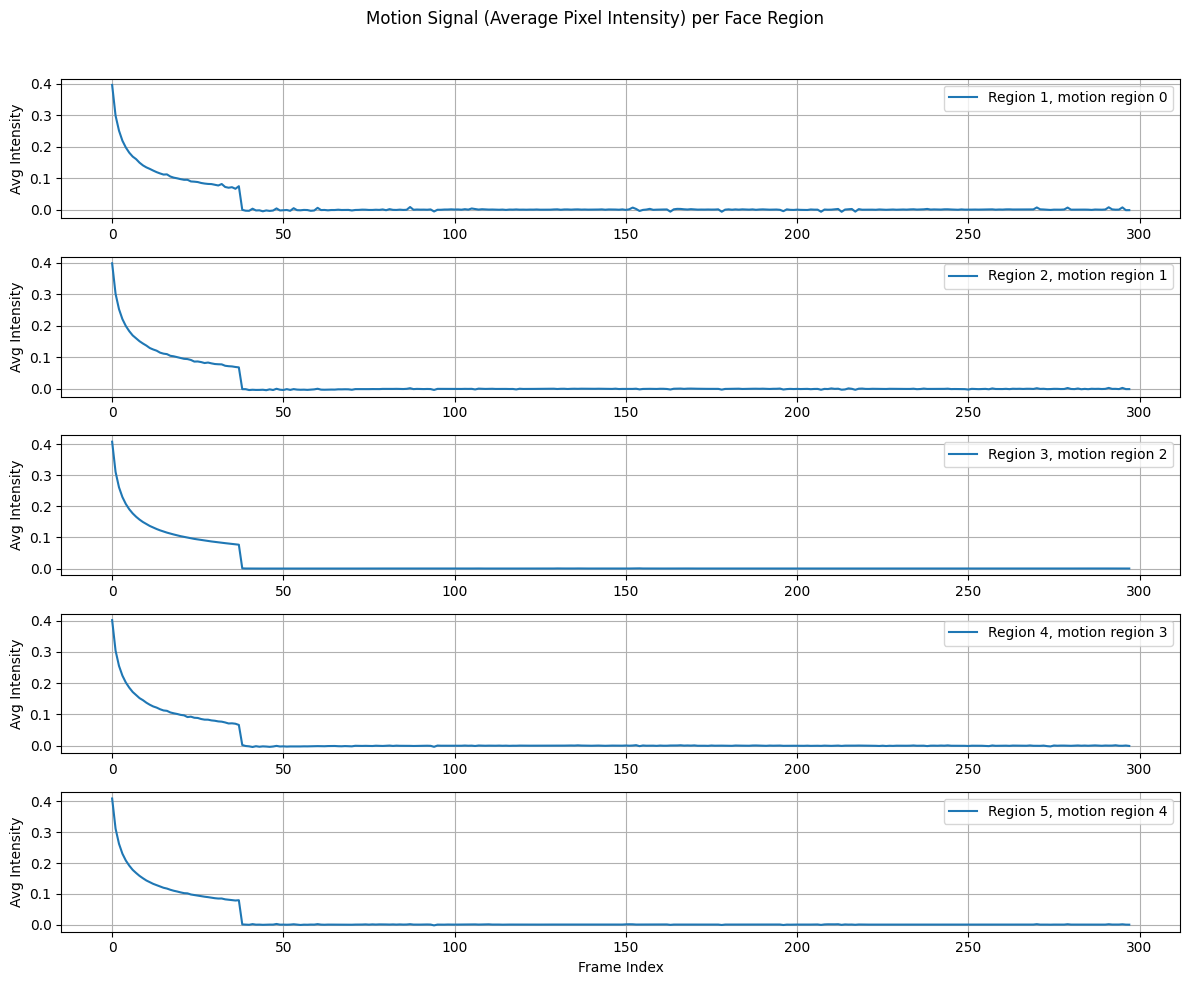

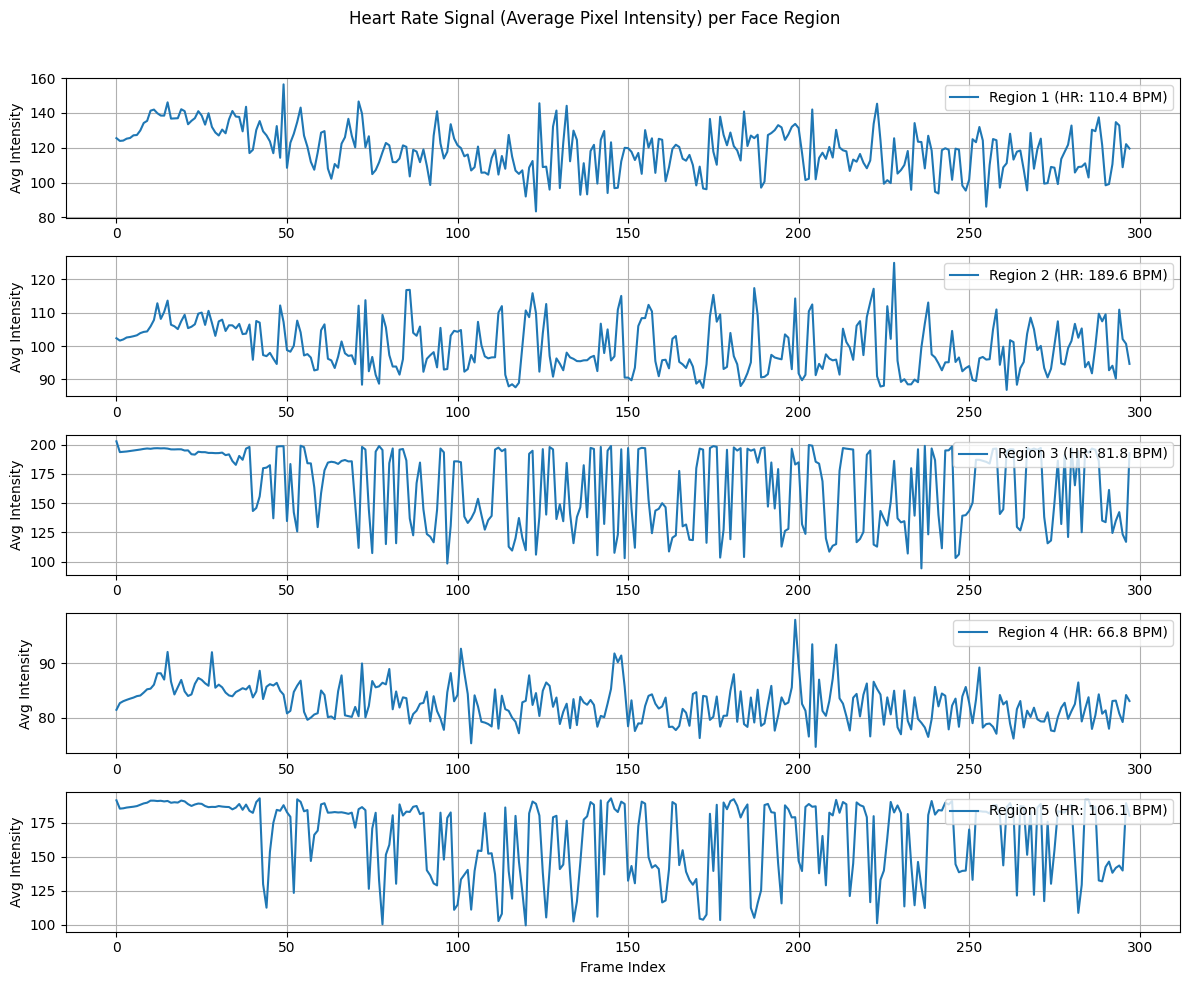

In [9]:
fps = 30



# Load the .npy file
# Replace 'your_file.npy' with the actual path to your .npy file


# ---------------------------
# Helper Functions
# ---------------------------
def complex_mag(x):
    """Return the magnitude of complex value(s)."""
    return np.abs(x)

def signal_process_alter(pix_intensity, fps):
    """
    Process the pixel intensity signal via FFT bandpass filtering between 0.5 Hz and 3.0 Hz
    to estimate the heart rate.
    
    Parameters:
      pix_intensity (1D array): Averaged pixel intensity signal.
      fps (float): Frames per second.
      
    Returns:
      average (float): Estimated heart rate (BPM).
      top5freqs (1D array): Top 5 frequency components (Hz).
    """
    sampling_rate = fps
    lowcut_heart = 0.5
    highcut_heart = 4.0

    N = len(pix_intensity)  # Signal length
    T = 1.0 / sampling_rate  # Sampling interval
    coefs = np.fft.fft(pix_intensity)  # FFT of the signal
    freqs = np.fft.fftfreq(N, T)       # Frequency bins

    # Select frequencies within the heart rate band.
    indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))
    coefsinrange = coefs[indices]
    freqsinrange = freqs[indices]

    # Select top 5 frequency components based on FFT coefficient magnitude.
    max_indicies = np.argsort(complex_mag(coefsinrange))[-5:]
    coefsinrange = coefsinrange[max_indicies]
    freqsinrange = freqsinrange[max_indicies]

    # Compute a weighted average frequency (Hz) then convert to BPM.
    FFT_heart_rate = np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange))
    average = FFT_heart_rate * 60

    top5indices = np.argsort(complex_mag(coefsinrange))[-5:]
    top5freqs = freqsinrange[top5indices]

    return average, top5freqs

def motion_process_5regions(data, window_size, phi_tol):
    """
    Process motion for face regions when the input data is organized as:
         data[frame][region]
    For example, if there are T frames and 5 regions per frame, then data is a list of T elements,
    each being a list of 5 images (each image shape: (H, W, 3)).
    
    The function performs temporal normalization using a sliding window, computes frame-to-frame
    differences, and then evaluates a phi value between consecutive difference frames. A phi mask
    (bitmask) is created for each region (for valid frames only) such that a pixel is marked good (1)
    if the phi value is ≥ phi_tol; otherwise 0.
    
    Returns:
      motion_data: A list of length T, where each element is a list of 5 arrays (one per region)
                   of shape (H, W, 3) representing the motion-filtered images.
      phi_bitmask: A list of length T, where each element is a list of 5 phi bitmask arrays (or None)
                   for each region. (A phi mask is computed for frames 1 to T-2; frames 0 and T-1 are None.)
      phi_tol:     The phi tolerance value used.


    *Uses BLANK method to account for irregularities in camera startup. 
    """
    T = len(data)
    num_regions = len(data[0])
    
    # ------------------------------------------------
    # Reorganize data per region: each region as a time series.
    # ------------------------------------------------
    regions = []
    for r in range(num_regions):
        # For each region, collect the same region across all frames.
        region_frames = [data[t][r] for t in range(T)]
        regions.append(np.stack(region_frames, axis=0))  # shape (T, H, W, 3)
    
    motion_data_regions = []  # to store motion per region (shape: (T, H, W, 3))
    region_masks_all = []     # to store phi masks for each region (list length T-2 per region)
    
    for region in regions:
        R = region.copy().astype(np.float32)
        # -------------------------------
        # Temporal normalization using a sliding window.
        # -------------------------------
        for t in range(T):
            start = max(0, t - window_size + 1)
            end = t + 1  # window covers frames start...t
            window = R[start:end]
            mean_val = window.mean(axis=(0, 1, 2), keepdims=True)
            std_val = window.std(axis=(0, 1, 2), keepdims=True) + 1e-8
            R[t] = (R[t] - mean_val) / std_val
        
        # -------------------------------
        # Compute motion differences (frame-to-frame differences)
        # -------------------------------
        motion = np.zeros_like(R)
        for t in range(T - 1):
            motion[t] = R[t+1] - R[t]
        # The last frame remains zeros.
        
        # -------------------------------
        # Compute phi masks based on consecutive motion difference frames.
        # The computed phi for a pixel in frame t+1 comes from motion[t] and motion[t+1].
        # We have valid phi values for frames 1 to T-2.
        # -------------------------------
        masks = []
        for t in range(0, T - 2, 1):
            
            C_t = motion[t]
            C_t1 = motion[t+1]

            norm_C_t = np.linalg.norm(C_t, axis=-1, keepdims=True) + 1e-8
            norm_C_t1 = np.linalg.norm(C_t1, axis=-1, keepdims=True) + 1e-8

            C_t_normalized = C_t / norm_C_t
            C_t1_normalized = C_t1 / norm_C_t1

            phi = np.sum(C_t1_normalized * C_t_normalized, axis=-1)  # shape: (H, W)
        
            # # quick sanity check inside your loop
            # print(f'frame {t}: true min(phi) = {phi.min()}')

            # assert (phi >= 0).all()          # should never fail
            
            mask = (phi >= phi_tol).astype(np.uint8)
            masks.append(mask)

            

        
        motion_data_regions.append(motion)
        region_masks_all.append(masks)
    
    # ------------------------------------------------
    # Convert per-region outputs back to frame-first indexing.
    # ------------------------------------------------
    # motion_data: list with length T; each element is a list of 5 regions' motion data.
    motion_data = []
    for t in range(T):
        frame_motion = []
        for r in range(num_regions):
            frame_motion.append(motion_data_regions[r][t])
        motion_data.append(frame_motion)
    
    # phi_bitmask: create a list of length T where each element is a list of 5 phi masks.
    # Valid phi masks are available for frames 1 to T-2. For frames 0 and T-1, store None.
    phi_bitmask = []
    for t in range(T):
        frame_masks = []
        for r in range(num_regions):
            if 1 <= t < T - 1:
                # The mask for frame t is stored at index t-1 in the region's mask list.
                frame_masks.append(region_masks_all[r][t - 1])
            else:
                frame_masks.append(None)
        phi_bitmask.append(frame_masks)
    
    return motion_data, phi_bitmask, phi_tol

# ---------------------------
# Driver Code
# ---------------------------
def main():
    # --- Simulation parameters ---
    data = np.load('/Users/henryschnieders/Documents/Research/My_Data/red_noise_2_6_2_regions.npy', allow_pickle=True)
    
    


    T = len(data)      # total number of frames in each video region
    num_regions = 5     # e.g., 5 face regions per frame


    # --- Compute motion data and phi bitmask ---

    #algorithm for determining window size and angle tolerance
    window_size = 20  # size of the sliding window for temporal normalization
    motion_data, phi_bitmask, used_phi_tol = motion_process_5regions(data, window_size=40, phi_tol=0.90) #phi tol in radians, window size
    
    # --- Build the average pixel intensity signal per face region ---
    # For each frame with a valid phi mask (frames 1 to T-2), compute the average pixel intensity
    # over the "good" pixels (those with mask value 1) for each region.
    region_signals = [[] for _ in range(num_regions)]
    
    for t in range(1,T-1,1):                 #phi masks are valid for frames 1 to T-2
        for r in range(num_regions):

            mask = phi_bitmask[t][r]

            if mask is not None:

                print(f"Processing frame {t}, region {r+1} with mask shape: {mask.shape}")

                # Get the corresponding original frame for face region r.
                frame = data[t][r]
                # Convert to grayscale by averaging the three channels.
                gray_frame = np.mean(frame, axis=-1)
                # Select only the "good" pixels (mask == 1).
                good_pixels = gray_frame[mask == 1]
                if good_pixels.size > 0:
                    avg_intensity = np.mean(good_pixels)
                    print(f"Frame {t}, Region {r+1}: good_pixel_count = {good_pixels.size}, avg_intensity = {avg_intensity:.2f}")
                else:
                    avg_intensity = 0.0
                region_signals[r].append(avg_intensity)

            else:

                # For frames without a valid phi mask, store 0.
                region_signals[r].append(0.0)
    

    motion_signals = [[] for _ in range(num_regions)]
    
    for t in range(1,T-1,1):                 #phi masks are valid for frames 1 to T-2
        for r in range(num_regions):
            motion_signals[r].append(np.mean(motion_data[t][r]))

    # Convert each region's signal to a NumPy array.
    motion_signals = [np.array(signal) for signal in motion_signals]
    
    # --- Process the intensity signals to compute heart rate per region ---
    region_heart_rates = []
    for r in range(num_regions):
        # Remove NaN values from the signal.
        valid_signal = region_signals[r]
        if len(valid_signal) > 0:
            hr, top5freqs = signal_process_alter(valid_signal, fps)
        else:
            hr, top5freqs = 0, np.array([])
        region_heart_rates.append(hr)
        print(f"Region {r+1}: Estimated Heart Rate = {hr:.2f} BPM, Top Frequencies (Hz) = {top5freqs}")
    
    # --- Plot the heart rate (average intensity) signal for each region ---
    plt.figure(figsize=(12, 10))
    for r in range(num_regions):
        plt.subplot(num_regions, 1, r+1)
        plt.plot(motion_signals[r], label=f"Region {r+1}, motion region {r}")
        plt.ylabel("Avg Intensity")
        plt.legend(loc="upper right")
        plt.grid('on')
        if r == num_regions - 1:
            plt.xlabel("Frame Index")
    plt.suptitle("Motion Signal (Average Pixel Intensity) per Face Region")
    plt.tight_layout(rect=[0, 0, 1, 0.96])

        # --- Plot the heart rate (average intensity) signal for each region ---
    plt.figure(figsize=(12, 10))
    for r in range(num_regions):
        plt.subplot(num_regions, 1, r+1)
        plt.plot(region_signals[r], label=f"Region {r+1} (HR: {region_heart_rates[r]:.1f} BPM)")
        plt.ylabel("Avg Intensity")
        plt.legend(loc="upper right")
        plt.grid('on')
        if r == num_regions - 1:
            plt.xlabel("Frame Index")
    plt.suptitle("Heart Rate Signal (Average Pixel Intensity) per Face Region")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
if __name__ == "__main__":
    main()


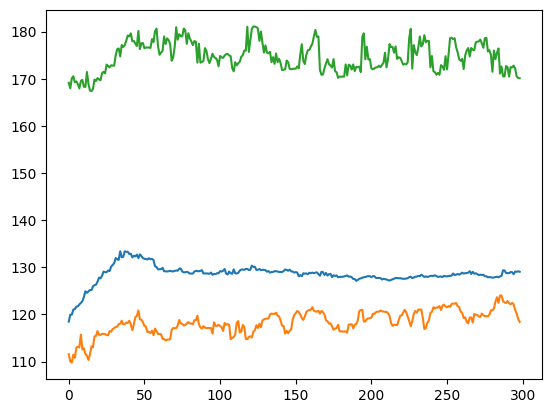

BPM per region: [np.float64(34.07970583097773), nan, np.float64(36.56100464037832), nan, np.float64(42.49655343946056)]


In [8]:
fps = 30
region_signals = traces                  # output from fb_track_regions
hr_estimates   = []

for sig in region_signals:

    ok = ~np.isnan(sig)
    if ok.sum() > 5:                     # need ≥ 5 valid samples
        hr, _ = signal_process_alter(sig[ok], fps)

        plt.plot(sig[ok], label=f"Region {len(hr_estimates)+1} (HR: {hr:.1f} BPM)")
    else:
        hr = np.nan
    hr_estimates.append(hr)

plt.show()
print("BPM per region:", hr_estimates)